In [161]:
import numpy as np
import h5py
import sys


sys.path.append(".")
dirname = "./bgw_files/k-2x2x2/"

In [162]:
# epsinp and sigmain data.
from qtm.interfaces.bgw.epsinp import Epsinp
epsinp = Epsinp.from_epsilon_inp(filename=dirname+'epsilon.inp')

from qtm.interfaces.bgw.sigmainp import Sigmainp
sigmainp = Sigmainp.from_sigma_inp(filename=dirname+'sigma.inp')

In [163]:
from qtm.interfaces.bgw import inp
from qtm.interfaces.bgw.wfn2py import wfn2py

# Read wfndata
wfndata = wfn2py(dirname + "WFN.h5")
wfnqdata = wfn2py(dirname + "WFNq.h5")

# Read rho
rho = inp.read_rho(dirname + "RHO")

# Read vxc 
vxc = inp.read_vxc(dirname + "vxc.dat") 

In [164]:
from qtm.gw.core import QPoints
from qtm.gw.epsilon import Epsilon

epsilon = Epsilon.from_data(wfndata=wfndata, wfnqdata=wfnqdata, epsinp=epsinp)

Vcoul calculation for qpts: 100%|██████████| 8/8 [00:00<00:00, 19032.58it/s]


In [165]:
from tqdm import trange
from qtm.gw.core import reorder_2d_matrix_sorted_gvecs, sort_cryst_like_BGW


def calculate_epsilon(numq=None, writing=False):
    epsmats = []
    if numq is None:
        numq = epsilon.qpts.numq

    for i_q in trange(0, numq, desc="Epsilon> q-pt index"):
        # Create map between BGW's sorting order and QTm's sorting order
        gkspc = epsilon.l_gq[i_q]
        
        if i_q == epsilon.qpts.index_q0:
            key = gkspc.g_norm2
        else:
            key = gkspc.gk_norm2

        indices_gspace_sorted = sort_cryst_like_BGW(
            cryst=gkspc.g_cryst, key_array=key
        )
       

        # Calculate matrix elements
        M = next(epsilon.matrix_elements(i_q=i_q))

        # Calculate polarizability matrix (faster, but not memory-efficient)
        chimat = epsilon.polarizability(M)

        # Calculate polarizability matrix (memory-efficient)
        # chimat = epsilon.polarizability_active(i_q)

        # Calculate epsilon inverse matrix
        epsinv0 = epsilon.epsilon_inverse(i_q=i_q, polarizability_matrix=chimat, store=True)
        epsinv = reorder_2d_matrix_sorted_gvecs(epsinv0, indices_gspace_sorted)

        epsilon.l_epsinv[i_q] = epsinv

        
        # Compare the results with BGW's results
        if i_q == epsilon.qpts.index_q0:
            epsref = epsilon.read_epsmat(dirname + "eps0mat.h5")[0][0, 0]
            if writing:
                epsilon.write_epsmat(
                    filename="test/epsilon/eps0mat_qtm.h5", epsinvmats=[epsinv]
                )
        else:
            epsref = np.array(epsilon.read_epsmat(dirname + "epsmat.h5")[i_q - 1][0, 0])
            epsmats.append(epsinv)

        # Calculate stddev between reference and calculated epsinv matrices
        std_eps = np.std(epsref - epsinv) / np.sqrt(np.prod(list(epsinv.shape)))


        epstol = 1e-16
        if np.abs(std_eps) > epstol:
            print(f"Standard deviation exceeded {epstol} tolerance: {std_eps}, for i_q:{i_q}")


    if writing:
        epsilon.write_epsmat(filename="test/epsilon/epsmat_qtm.h5", epsinvmats=epsmats)


epsinp.no_min_fftgrid = True
epsilon = Epsilon.from_data(wfndata=wfndata, wfnqdata=wfnqdata, epsinp=epsinp)

calculate_epsilon()

Epsilon> q-pt index: 100%|██████████| 8/8 [00:00<00:00, 142.51it/s]

Standard deviation exceeded 1e-16 tolerance: 2.5494915419483335e-15, for i_q:0


In [166]:
from kernel import KernelMtxEl

q0val = [0.001, 0.001, 0.001]


In [167]:
kernelclass = KernelMtxEl.from_BGW(
    wfndata=wfndata,
    epsinp=epsinp,
    sigmainp=sigmainp,
    l_epsmats=epsilon.l_epsinv,
    q0=q0val,
    parallel=False,
    num_bands_val=4,
    num_bands_con=4,
)

In [168]:
data = kernelclass.kernel_mtxel()

In [169]:
# exc = data["exc"]
# print(exc.shape)
# exc = exc[:, 0, 0, 0, :, 0]

# for row in range(exc.shape[0]):
#     row_data = []
#     for col in range(exc.shape[1]):
#         row_data.append(f"{exc[row, col]:.5f}")
#     print(" | ".join(row_data))

In [170]:
# head = data["head"]
# head = head[:, 0, 0, 0, :, 0]

# for row in range(head.shape[0]):
#     row_data = []
#     for col in range(head.shape[1]):
#         row_data.append(f"{head[row, col]:.5f}")
#     print(" | ".join(row_data))

In [171]:
# wings = data["wings"]
# wings = wings[:, 0, 0, 0, :, 0]

# for row in range(wings.shape[0]):
#     row_data = []
#     for col in range(wings.shape[1]):
#         row_data.append(f"{wings[row, col]:.5f}")
#     print(" | ".join(row_data))

In [172]:
# body = data["body"]
# body = body[:, 0, 0, 0, :, 0]

# for row in range(body.shape[0]):
#     row_data = []
#     for col in range(body.shape[1]):
#         row_data.append(f"{body[row, col]:.5f}")
#     print(" | ".join(row_data))

In [173]:
exc_QTM = data["exc"]
head_QTM = data["head"]
wings_QTM = data["wings"]
body_QTM = data["body"]

print(exc_QTM.shape)
print(head_QTM.shape)
print(wings_QTM.shape)
print(body_QTM.shape)

(8, 8, 4, 4, 4, 4)
(8, 8, 4, 4, 4, 4)
(8, 8, 4, 4, 4, 4)
(8, 8, 4, 4, 4, 4)


In [174]:
with h5py.File(dirname + 'bsemat.h5', 'r') as f:
    body_BGW = f['mats/body']
    head_BGW = f['mats/head']
    wings_BGW = f['mats/wing']
    exc_BGW = f['mats/exchange']

    body_BGW = body_BGW[..., 0] + body_BGW[..., 1] * 1j
    head_BGW = head_BGW[..., 0] + head_BGW[..., 1] * 1j
    wings_BGW = wings_BGW[..., 0] + wings_BGW[..., 1] * 1j
    exc_BGW = exc_BGW[..., 0] + exc_BGW[..., 1] * 1j

    print("Body_BGW", body_BGW.shape)
    print("Head_BGW", head_BGW.shape)
    print("Wings_BGW", wings_BGW.shape)
    print("Exc_BGW", exc_BGW.shape)

Body_BGW (8, 8, 4, 4, 4, 4)
Head_BGW (8, 8, 4, 4, 4, 4)
Wings_BGW (8, 8, 4, 4, 4, 4)
Exc_BGW (8, 8, 4, 4, 4, 4)


In [175]:
exc_BGW = exc_BGW.transpose(1, 0, 3, 2, 5, 4)
body_BGW = body_BGW.transpose(1, 0, 3, 2, 5, 4)
head_BGW = head_BGW.transpose(1, 0, 3, 2, 5, 4)
wings_BGW = wings_BGW.transpose(1, 0, 3, 2, 5, 4)

In [176]:
diff_exc = np.abs(exc_BGW - exc_QTM)
sum_exc = diff_exc.sum(axis=(2, 3, 4, 5))
norm_diff_exc = sum_exc / (4 * 4 * 4 * 4)

In [177]:
diff_body = np.abs(body_BGW - body_QTM)
sum_body = diff_body.sum(axis=(2, 3, 4, 5))
norm_diff_body = sum_body / (4 * 4 * 4 * 4)

In [178]:
diff_head = np.abs(head_BGW - head_QTM)
sum_head = diff_head.sum(axis=(2, 3, 4, 5))
norm_diff_head = sum_head / (4 * 4 * 4 * 4)

In [179]:
diff_wings = np.abs(wings_BGW - wings_QTM)
sum_wings = diff_wings.sum(axis=(2, 3, 4, 5))
norm_diff_wings = sum_wings / (4 * 4 * 4 * 4)

In [180]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator

# 1) set global font to CMU Serif
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.family']  = 'serif'
mpl.rcParams['font.serif']   = ['CMU Serif']    # make sure CMU Serif is installed
mpl.rcParams['text.usetex']        = False    # or True, if you have a full LaTeX install
mpl.rcParams['mathtext.fontset']   = 'cm'     # use Computer Modern for math
mpl.rcParams['mathtext.default']   = 'regular'

def plot_norm_diff(norm_diff, save_name = "save", title='kernel', cmap_limits=None, max_ticks=10):
    """
    norm_diff : 2D array to image
    title     : plot title
    cmap_limits : (vmin, vmax) tuple or None
    max_ticks : maximum number of tick labels along each axis
    """
    k1, k2 = norm_diff.shape

    fig, ax = plt.subplots(figsize=(6, 5))

    im = ax.imshow(
        norm_diff,
        origin='lower',
        aspect='auto',
        cmap='gist_heat',                      # 2) use red‐toned colormap
        vmin=None if cmap_limits is None else cmap_limits[0],
        vmax=None if cmap_limits is None else cmap_limits[1],
    )

    # 3) throttle the number of major tick labels
    ax.xaxis.set_major_locator(MaxNLocator(nbins=max_ticks, integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=max_ticks, integer=True))

    # keep the white grid between cells
    ax.set_xticks(np.arange(-.5, k2, 1), minor=True)
    ax.set_yticks(np.arange(-.5, k1, 1), minor=True)
    ax.grid(which='minor', color='white', linestyle='-', linewidth=0.5)
    ax.tick_params(which='minor', bottom=False, left=False)

    cbar = plt.colorbar(im, ax=ax)
    ax.set_xlabel(r'$k_{1}$')
    ax.set_ylabel(r"$k_{2}$")
    ax.set_title(title)
    plt.tight_layout()

    fname = save_name + '.png'
    fig.savefig(fname, dpi=1200, bbox_inches='tight')
    print(f"Saved figure as {fname}")
    plt.show()


In [181]:
# plot_norm_diff(norm_diff_exc, title="Exchange Kernel", cmap_limits=(0, 1e-10))

In [182]:
# plot_norm_diff(norm_diff_head, title="Head Kernel", cmap_limits=(0, 1e-10))

In [183]:
# plot_norm_diff(norm_diff_body, title="Body Kernel",)


In [184]:
# plot_norm_diff(norm_diff_wings, title="Wings Kernel",)

In [185]:
norm_diff_mvc = np.zeros((4, 4))
norm_diff_mccp = np.zeros((4, 4))
norm_diff_mvvp = np.zeros((4, 4))

norm_diff_dvv = np.zeros((4, 4))
norm_diff_dcc = np.zeros((4, 4))

In [186]:
# plot_norm_diff(norm_diff_mvc, save_name="mvc", title=r"$M_{vc}(k_{3}, k'_{7})$", cmap_limits=(0, 1e-10))

# plot_norm_diff(norm_diff_mccp, save_name="mccp", title=r"$M_{cc'}(k_{3}, k'_{7})$", cmap_limits=(0, 1e-10))

# plot_norm_diff(norm_diff_mvvp, save_name="mvvp", title=r"$M_{vv'}(k_{3}, k'_{7})$", cmap_limits=(0, 1e-10))

# plot_norm_diff(norm_diff_dvv, save_name="dvv", title=r"$C^{k_{co}}_{vv}(k^{fi}_{3}, k^{co}_{7})$", cmap_limits=(0, 1e-10))

# plot_norm_diff(norm_diff_dcc, save_name="dcc", title=r"$C^{k_{co}}_{cc}(k^{fi}_{3}, k^{co}_{7})$", cmap_limits=(0, 1e-10))


Saved figure as velmtx.png


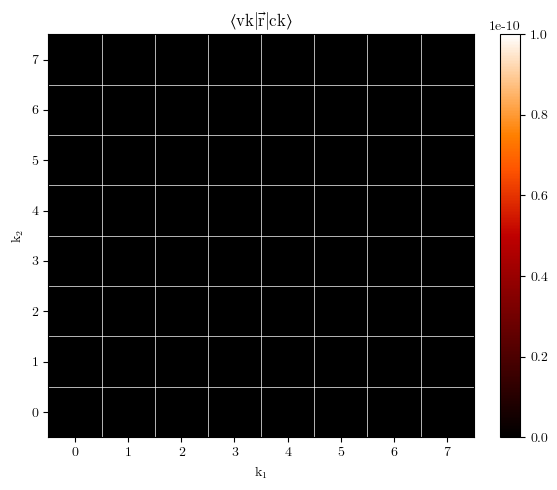

In [189]:
diff_norm_velmtx = np.zeros((8,8))
plot_norm_diff(diff_norm_velmtx, save_name="velmtx", title=r"$\langle vk|\vec r|ck\rangle$", cmap_limits=(0, 1e-10))
